I am working with data that has game review from Steam store.
By exploring this data, I aim to build a system that can recommend games to the potential buyers by capturing what games they gave reviews for and what their opinions were.

### import necessary toolsets

In [1]:
import json
import pandas as pd
import os
import string
import re # regular expression toolkit
import nltk # Natural language toolkit
from collections import defaultdict
from pandas.io.json import json_normalize
import requests

get data from steam website

In [2]:
api_key='3A629E52AE594CB777253431189F2967' # API key for getting information from Steam

In [3]:
def getownedgames(idnum):
    url='http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key=3A629E52AE594CB777253431189F2967&steamid={}&format=json'.format(idnum)
    r=requests.get(url)
    json_data=r.json()
    return json_data

In [4]:
kk=getownedgames(76561198070249881)

In [5]:
kk['response']['games']

[{'appid': 4000, 'playtime_forever': 432},
 {'appid': 22330, 'playtime_forever': 1307},
 {'appid': 6060, 'playtime_forever': 94},
 {'appid': 6000, 'playtime_forever': 37},
 {'appid': 32370, 'playtime_forever': 1194},
 {'appid': 12830, 'playtime_forever': 1},
 {'appid': 39540, 'playtime_forever': 21},
 {'appid': 550, 'playtime_forever': 446},
 {'appid': 22370, 'playtime_forever': 751},
 {'appid': 33910, 'playtime_forever': 648},
 {'appid': 33930, 'playtime_forever': 28},
 {'appid': 219540, 'playtime_forever': 0},
 {'appid': 8930, 'playtime_forever': 1130},
 {'appid': 39500, 'playtime_forever': 0},
 {'appid': 39510, 'playtime_forever': 0},
 {'appid': 65540, 'playtime_forever': 2},
 {'appid': 47810, 'playtime_forever': 3225},
 {'appid': 20920, 'playtime_forever': 1397},
 {'appid': 65800, 'playtime_forever': 365},
 {'appid': 22380, 'playtime_forever': 2487},
 {'appid': 104900, 'playtime_forever': 350},
 {'appid': 91310, 'playtime_forever': 20},
 {'appid': 211420, 'playtime_forever': 847},


In [6]:
k_df=pd.DataFrame(kk['response']['games'])

In [7]:
def get_reviews(gameid):
    url='http://store.steampowered.com/appreviews/{}?json=1 '.format(gameid)
    r=requests.get(url)
    json_data=r.json()
    return json_data

In [8]:
pp=get_reviews(4000)
ww=pd.DataFrame(pp['reviews'])
pwpp=dict(ww['author'][0])
pwpp['steamid']
steamids=list()
for i in range(len(ww)):
    pwpp=dict(ww['author'][i])
    steamids.append(pwpp['steamid'])
ww['author']=steamids

ww

,author,comment_count,language,received_for_free,recommendationid,review,steam_purchase,timestamp_created,timestamp_updated,voted_up,votes_funny,votes_up,weighted_vote_score,written_during_early_access
0,76561198075734318,0,english,False,48154828,Its alright.,True,1546805539,1546805539,True,145,74,0.801690638065338135,False
1,76561198818249766,0,english,False,48292046,This Game Could Be Extremely Fun....\nIF You P...,True,1547338791,1547338791,True,10,60,0.732597768306732178,False
2,76561198847259953,9,english,False,48109966,"shrek is love, shrek is life, shrek will steal...",True,1546651615,1546651615,True,465,157,0.759794652462005615,False
3,76561198050787907,0,english,False,48672725,This game lets you experience some of the fine...,True,1548958887,1548958887,True,16,16,0.700598776340484619,False
4,76561198150170612,0,english,False,48660057,Some bisexual kid farmed out 80 hours on this ...,True,1548910714,1548910808,True,18,15,0.679076671600341797,False
5,76561198423762945,1,english,False,48418355,A game in which your imagination has no bounda...,True,1547897636,1547897636,True,6,14,0.631382942199707031,False
6,76561198271490778,1,english,False,48247434,Just get this game. It has unlimited modes and...,True,1547190938,1547758358,True,0,8,0.588766872882843018,False
7,76561198874640093,0,english,False,48579238,"Great game, not only can you relax by yourself...",True,1548557444,1548557444,True,0,8,0.574803173542022705,False
8,76561198271920441,0,english,False,48160462,actually the best game ive ever played,True,1546826714,1546826714,True,0,7,0.528571426868438721,False
9,76561198066588335,0,english,False,48410639,I joined a cinema filled with 13 year olds wat...,True,1547858745,1547858745,True,4,4,0.525773227214813232,False


### get data from folder and save file names

In [9]:
folder='E:/Desktop/jupyter/Capstone1-master/DATA/steam_reviews-master/steam_reviews-master/data/'

In [10]:
filenames=os.listdir(folder)

In [11]:
filenames[1]

'Arma_3.jsonlines'

### define function to get data from each file

In [12]:
def get_jsonline(file_name):
    data=[]
    with open(file_name) as f:
        for line in f:
            data.append(json.loads(line))
    return data

### make a first dataframe that will serve as frame for other data

In [13]:
for name in filenames:
    if name.endswith(".jsonlines"):
        data=json_normalize(get_jsonline(folder+name))
        df=pd.DataFrame(data)
        df=df[['rating','review','steam_id_number','total_game_hours','total_game_hours_last_two_weeks','username']]
        df['game_name']=name.split('.')[0]
        if 'review_df' not in locals():
            review_df=df
        else:
            review_df=review_df.append(df, ignore_index=True, sort=False)
    else:
        continue

In [14]:
review_df.head()

,rating,review,steam_id_number,total_game_hours,total_game_hours_last_two_weeks,username,game_name
0,Recommended,My first game on A3 brought me the most horrif...,thisisthefallout,580.3,58.7,King Pootis,Arma_3
1,Recommended,This is not a game for people who want fast ac...,PeaceFaker,122.2,2.8,Peace,Arma_3
2,Recommended,Oh man. Where to even begin with this one. It ...,TheDanius,731.4,38.2,[13th] Danius,Arma_3
3,Recommended,This is quite possibly the most emotional shoo...,ArtificialApple,291.8,25.2,ArtificialApple,Arma_3
4,Recommended,"If you have friends, this is a great game to p...",76561198058863036,46.8,0.1,Sir Quad Kill aka Sir Charlie,Arma_3


In [15]:
print(list(review_df))
print(len(review_df))

['rating', 'review', 'steam_id_number', 'total_game_hours', 'total_game_hours_last_two_weeks', 'username', 'game_name']
79437


## extract only the review section from each game data and clean them up for analysis

### extract words or bigrams from the reviews

In [16]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shshi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shshi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shshi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [17]:
raw_review=review_df['review']
raw_review.head()

0    My first game on A3 brought me the most horrif...
1    This is not a game for people who want fast ac...
2    Oh man. Where to even begin with this one. It ...
3    This is quite possibly the most emotional shoo...
4    If you have friends, this is a great game to p...
Name: review, dtype: object

In [18]:
raw_review.isnull().sum()

0

In [19]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = stopwords.words('english')+list(string.punctuation)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
def vect(text):
    cvt=CountVectorizer(stop_words="english", analyzer='word')
    X=cvt.fit_transform(text)
    return X.toarray(), cvt.get_feature_names()

In [22]:
def tdfvect(text):   
    tfidf=TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word', stop_words="english")
    X=tfidf.fit_transform(text)
    return X.toarray(),tfidf.get_feature_names()

In [23]:
working_data=review_df.loc[(review_df['game_name'] == 'Warframe')]

In [24]:
freq,words=vect(working_data['review'])
tdfscore,tdfwords=tdfvect(working_data['review'])

In [25]:
result=list(zip(tdfscore,tdfwords))

In [26]:
print(result[1][0].sum())

220.67022397122508


In [27]:
list(zip(words,freq.sum(axis=0)))

[('00', 6),
 ('000', 31),
 ('00gb', 1),
 ('01', 3),
 ('02', 1),
 ('024', 1),
 ('03', 2),
 ('04', 3),
 ('040', 1),
 ('06', 1),
 ('08', 5),
 ('0_o', 2),
 ('0hrs', 1),
 ('10', 1546),
 ('100', 164),
 ('1000', 35),
 ('10000', 3),
 ('1000000', 1),
 ('1000000000000', 1),
 ('1000hr', 1),
 ('1000m', 1),
 ('1000th', 1),
 ('1000times', 1),
 ('1000x', 1),
 ('100h', 1),
 ('100hrs', 1),
 ('100k', 3),
 ('100mountaindew', 1),
 ('100s', 5),
 ('100th', 1),
 ('100x', 1),
 ('100xp', 1),
 ('103', 1),
 ('104', 1),
 ('1080', 2),
 ('1080p', 1),
 ('10gb', 2),
 ('10h', 3),
 ('10k', 1),
 ('10sec', 2),
 ('10x', 3),
 ('11', 152),
 ('110', 3),
 ('1100', 2),
 ('111', 1),
 ('1120', 1),
 ('116hrs', 1),
 ('12', 142),
 ('120', 5),
 ('1200', 2),
 ('123', 1),
 ('123achievments', 1),
 ('125', 1),
 ('125p', 1),
 ('126', 2),
 ('12645', 2),
 ('127419723921', 1),
 ('1280', 1),
 ('1280x720', 1),
 ('12h', 6),
 ('12hr', 2),
 ('12hrs', 2),
 ('12p', 2),
 ('13', 36),
 ('1300', 2),
 ('132', 2),
 ('1337', 1),
 ('14', 53),
 ('140p', 1)

In [28]:
scoring=pd.DataFrame(tdfscore.sum(axis=0),index=tdfwords,columns=['score'])

In [29]:
scoring.head()

,score
00,48.475949
000,203.832669
00gb,9.871084
01,27.533811
02,9.871084


In [30]:
scoring.sort_values(by='score',ascending=False)

,score
game,18004.072882
warframe,8182.660993
play,7656.728984
weapons,6372.101036
like,6224.721263
fun,5569.553330
free,5317.709187
just,5306.562150
time,5239.025105
new,4947.858005


In [31]:
scoring_file=dict()
for name in review_df['game_name'].unique():
    working_data=review_df.loc[(review_df['game_name']==name)]
    freq,words=vect(working_data['review'])
    tdfscore,tdfwords=tdfvect(working_data['review'])
    result=list(zip(tdfscore,tdfwords))
    list(zip(words,freq.sum(axis=0)))
    scoring=pd.DataFrame(tdfscore.sum(axis=0),index=tdfwords,columns=['score'])
    scoring.sort_values(by='score',ascending=False)
    scoring_file[name]=scoring

In [32]:
names=list(scoring_file.keys())
for k in range(len(names)):
    if "idx1" not in locals():
        idx1=scoring_file[names[k]].index
    idx2=scoring_file[names[k]].index
    idx1=idx2.intersection(idx1)

In [33]:
idxlist=idx1.tolist()
print(idxlist)

['00', '000', '10', '100', '1000', '11', '12', '13', '14', '15', '150', '1500', '16', '17', '18', '19', '1st', '1v1', '20', '200', '2000', '2011', '2012', '2013', '2014', '2015', '21', '24', '25', '250', '2nd', '30', '300', '33', '3d', '3rd', '40', '400', '45', '48', '50', '500', '60', '600', '64', '65', '69', '70', '75', '80', '90', '95', '99', 'abilities', 'ability', 'abit', 'able', 'absolute', 'absolutely', 'absolutly', 'accept', 'access', 'accessible', 'according', 'account', 'accuracy', 'accurate', 'ace', 'achieve', 'achievement', 'achievements', 'act', 'action', 'actions', 'active', 'actual', 'actually', 'add', 'added', 'addicted', 'addicting', 'addiction', 'addictive', 'adding', 'addition', 'additional', 'adds', 'admit', 'advance', 'advanced', 'advantage', 'advice', 'advise', 'afford', 'afraid', 'age', 'ages', 'aggressive', 'ago', 'agree', 'ahead', 'ai', 'aim', 'ain', 'aint', 'air', 'alike', 'alive', 'allot', 'allow', 'allowed', 'allowing', 'allows', 'alot', 'alpha', 'alright', 

In [34]:
scoring_test=scoring_file

In [35]:
scoring_test.keys()

dict_keys(['Arma_3', 'Counter_Strike', 'Counter_Strike_Global_Offensive', 'Dota_2', 'Football_Manager_2015', 'Garrys_Mod', 'Grand_Theft_Auto_V', 'Sid_Meiers_Civilization_5', 'Team_Fortress_2', 'The_Elder_Scrolls_V', 'Warframe'])

In [36]:
arm=scoring_test['Arma_3']
arm.sort_values('score',ascending=False, inplace=True)
arm['rank']=arm['score'].rank(ascending=False,method='average')
arm.sort_values('rank',ascending=True)
print(arm)

                    score     rank
game         15118.547706      1.0
arma         10168.572761      2.0
like          6423.196366      3.0
10            6057.275997      4.0
play          5382.617826      5.0
just          4942.356105      6.0
good          4763.458456      7.0
great         4268.253403      8.0
fun           3881.335990      9.0
really        3737.511354     10.0
time          3383.338686     11.0
mods          3372.235149     12.0
best          3319.568036     13.0
games         3274.070872     14.0
military      3113.805554     15.0
buy           2993.706720     16.0
played        2897.474445     17.0
multiplayer   2895.517693     18.0
fps           2865.091761     19.0
life          2848.155339     20.0
people        2818.105629     21.0
don           2735.819237     22.0
want          2704.557519     23.0
playing       2701.351781     24.0
make          2689.867267     25.0
amazing       2662.589332     26.0
graphics      2614.272998     27.0
better        2578.4

In [37]:
armidx=scoring_test['Arma_3'].drop(index=idxlist)
armidx.sort_values('score',ascending=False, inplace=True)
armidx['rank']=armidx['score'].rank(ascending=False,method='average')
armidx.sort_values('rank',ascending=True)

,score,rank
arma,10168.572761,1.0
military,3113.805554,2.0
fps,2865.091761,3.0
missions,2382.618596,4.0
altis,2184.247908,5.0
vehicles,1876.091996,6.0
mission,1756.448407,7.0
bohemia,1749.448445,8.0
weapons,1707.396640,9.0
battlefield,1556.403027,10.0


In [38]:
armsin=armidx.join(arm, lsuffix='_new',rsuffix='_orig')
print(armsin)

                 score_new  rank_new    score_orig  rank_orig
arma          10168.572761       1.0  10168.572761        2.0
military       3113.805554       2.0   3113.805554       15.0
fps            2865.091761       3.0   2865.091761       19.0
missions       2382.618596       4.0   2382.618596       32.0
altis          2184.247908       5.0   2184.247908       42.0
vehicles       1876.091996       6.0   1876.091996       55.0
mission        1756.448407       7.0   1756.448407       60.0
bohemia        1749.448445       8.0   1749.448445       61.0
weapons        1707.396640       9.0   1707.396640       64.0
battlefield    1556.403027      10.0   1556.403027       79.0
controls       1383.717757      11.0   1383.717757       91.0
dayz           1378.258882      12.0   1378.258882       92.0
wasteland      1364.432447      13.0   1364.432447       94.0
maps           1320.821044      14.0   1320.821044      100.0
squad          1208.023173      15.0   1208.023173      118.0
editor  

In [39]:
origrank=armsin['rank_new']
newrank=armsin['rank_new']

In [40]:
from scipy.stats import spearmanr
coef,p=spearmanr(origrank,newrank)
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 1.000
Samples are correlated (reject H0) p=0.000


In [41]:
for name in scoring_file.keys():
    scoring_file[name]=scoring_file[name].drop(idx1).sort_values(by='score',ascending=False)

In [42]:
from textblob import TextBlob
sentiment=list()
for sentence in raw_review:
    senti = TextBlob(sentence)
    sentiment.append(senti.sentiment[0])
review_df['sentiment']=sentiment

In [43]:
review_df.head()

,rating,review,steam_id_number,total_game_hours,total_game_hours_last_two_weeks,username,game_name,sentiment
0,Recommended,My first game on A3 brought me the most horrif...,thisisthefallout,580.3,58.7,King Pootis,Arma_3,0.025809
1,Recommended,This is not a game for people who want fast ac...,PeaceFaker,122.2,2.8,Peace,Arma_3,0.054861
2,Recommended,Oh man. Where to even begin with this one. It ...,TheDanius,731.4,38.2,[13th] Danius,Arma_3,0.160172
3,Recommended,This is quite possibly the most emotional shoo...,ArtificialApple,291.8,25.2,ArtificialApple,Arma_3,0.033523
4,Recommended,"If you have friends, this is a great game to p...",76561198058863036,46.8,0.1,Sir Quad Kill aka Sir Charlie,Arma_3,0.016667


In [65]:
tpos=list()
tposnum=0

fpos=list()
fposnum=0

tneg=list()
tnegnum=0

fneg=list()
fnegnum=0

sentimentcol=review_df['sentiment']
ratingcol=review_df['rating']
for num in range(len(review_df)):
    if (sentimentcol[num]<0 and ratingcol[num]=="Recommended"):
        fpos.append(sentimentcol[num])
        fposnum=fposnum+1
    elif (sentimentcol[num]>0 and ratingcol[num]=="Not Recommended"):
        fneg.append(sentimentcol[num])
        fnegnum=fnegnum+1
    elif (sentimentcol[num]>0 and ratingcol[num]=="Recommended"):
        tpos.append(sentimentcol[num])
        tposnum=tposnum+1
    else:
        tneg.append(sentimentcol[num])
        tnegnum=tnegnum+1
accuracy=(tposnum+tnegnum)/(tposnum+tnegnum+fposnum+fnegnum)

In [66]:
print("Accuracy from textblob is", accuracy)

Accuracy from textblob is 0.7608545136397397


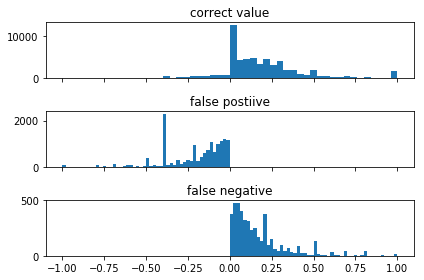

In [67]:
import matplotlib.pyplot as plt
data=(tpos+tneg,fpos,fneg)
titles=['correct value','false postiive','false negative']
f, a=plt.subplots(3,1,sharex=True)
a=a.ravel()
for idx, ax in enumerate(a):
    ax.hist(data[idx],bins=50)
    ax.set_title(titles[idx])
plt.tight_layout()

C:\Users\shshi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.37841364380338754


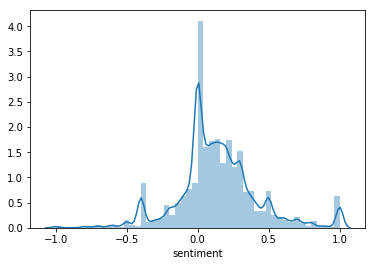

In [79]:
import seaborn as sns
import scipy.stats as stats
sns.distplot(recom['sentiment'])
print(stats.skew(recom['sentiment']))

C:\Users\shshi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


-0.3726301263966289


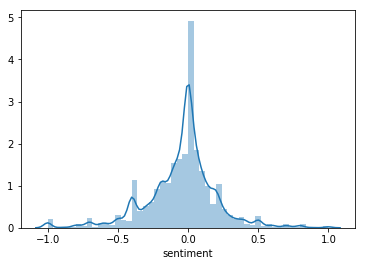

In [80]:
sns.distplot(nrecom['sentiment'])
print(stats.skew(nrecom['sentiment']))

In [85]:
test=k_df['appid'][0]

In [86]:
get_reviews(test)

{'success': 1,
 'query_summary': {'num_reviews': 20,
  'review_score': 9,
  'review_score_desc': 'Overwhelmingly Positive',
  'total_positive': 151173,
  'total_negative': 6675,
  'total_reviews': 157848},
 'reviews': [{'recommendationid': '48154828',
   'author': {'steamid': '76561198075734318',
    'num_games_owned': 143,
    'num_reviews': 10,
    'playtime_forever': 387451,
    'playtime_last_two_weeks': 2488,
    'last_played': 1549198080},
   'language': 'english',
   'review': 'Its alright.',
   'timestamp_created': 1546805539,
   'timestamp_updated': 1546805539,
   'voted_up': True,
   'votes_up': 74,
   'votes_funny': 145,
   'weighted_vote_score': '0.801690638065338135',
   'comment_count': 0,
   'steam_purchase': True,
   'received_for_free': False,
   'written_during_early_access': False},
  {'recommendationid': '48292046',
   'author': {'steamid': '76561198818249766',
    'num_games_owned': 31,
    'num_reviews': 7,
    'playtime_forever': 67601,
    'playtime_last_two_wee

## Testing with nltk and applying NaiveBayesClassifiers to achieve the same goal

In [46]:
import itertools
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
 
def bigram_word_feats(words, score_fn=BigramAssocMeasures.chi_sq, n=10):
    bigram_finder = BigramCollocationFinder.from_words(words)
    bigrams = bigram_finder.nbest(score_fn, n)
    return dict([(ngram, True) for ngram in itertools.chain(words, bigrams)])

tokenize all the review files

In [47]:
tokens=list()
clean_tokens=list()
for review in review_df['review']:
    token=word_tokenize(review)
    tokens.append(token)
    clean_token=[token for token in word_tokenize(review) if token not in stop_words]
    clean_tokens.append(clean_token)
review_df['tokens']=tokens
review_df['clean_tokens']=clean_tokens

In [48]:
recom=review_df[review_df['rating']=='Recommended']
nrecom=review_df[review_df['rating']=='Not Recommended']

In [50]:
negfeats=list()
posfeats=list()
for tokens in nrecom['tokens']:
    if len(set(tokens))<=1:
        continue
    negfeat=(bigram_word_feats(tokens),'Not Recommended')
    negfeats.append(negfeat)

for tokens in recom['tokens']:
    if len(set(tokens))<=1:
        continue
    posfeat=(bigram_word_feats(tokens),'Recommended')
    posfeats.append(posfeat)

In [93]:
print(negfeats[0:1])

[({'Pros': True, ':': True, '-': True, 'Most': True, 'wide': True, 'maps': True, 'of': True, 'any': True, 'shooting': True, 'game': True, 'that': True, 'I': True, 'have': True, 'played': True, '.': True, 'Mods': True, 'really': True, 'make': True, 'arma': True, 'Modding': True, 'community': True, 'is': True, 'good': True, 'Powerful': True, 'map': True, 'editor': True, 'and': True, 'scripting': True, 'language': True, 'Cons': True, 'Really': True, 'badly': True, 'implemented': True, 'multi-threading': True, 'resulting': True, 'in': True, 'horrible': True, 'performance': True, 'Inconsistent': True, 'buggy': True, 'with': True, 'many': True, 'flaws': True, 'Netcode': True, 'still': True, 'not': True, 'very': True, 'stable': True, 'Game': True, 'mods': True, 'require': True, 'approximately': True, '100GB': True, 'hard': True, 'disk': True, 'space': True, 'scattered': True, ',': True, 'so': True, 'compability': True, 'a': True, 'issue': True, 'Arma': True, 'generally': True, 'hugely': True,

In [51]:
import collections
import nltk.classify.util, nltk.metrics
from nltk.classify import NaiveBayesClassifier

negcutoff = round(len(negfeats)*3/4)
poscutoff = round(len(posfeats)*3/4)

trainfeats = negfeats[:negcutoff] + posfeats[:poscutoff]
testfeats = negfeats[negcutoff:] + posfeats[poscutoff:]

classifier = NaiveBayesClassifier.train(trainfeats)
refsets = collections.defaultdict(set)
testsets = collections.defaultdict(set)

for i, (features, label) in enumerate(testfeats):
    refsets[classifier.classify(features)].add(i)
    testsets[label].add(i)

In [110]:
len(posfeats[:poscutoff])

50294

In [109]:
len(negfeats[:negcutoff])

9018

In [103]:
len(recom)

67385

In [104]:
len(nrecom)

12052

In [108]:
trainfeats

[({'Pros': True,
   ':': True,
   '-': True,
   'Most': True,
   'wide': True,
   'maps': True,
   'of': True,
   'any': True,
   'shooting': True,
   'game': True,
   'that': True,
   'I': True,
   'have': True,
   'played': True,
   '.': True,
   'Mods': True,
   'really': True,
   'make': True,
   'arma': True,
   'Modding': True,
   'community': True,
   'is': True,
   'good': True,
   'Powerful': True,
   'map': True,
   'editor': True,
   'and': True,
   'scripting': True,
   'language': True,
   'Cons': True,
   'Really': True,
   'badly': True,
   'implemented': True,
   'multi-threading': True,
   'resulting': True,
   'in': True,
   'horrible': True,
   'performance': True,
   'Inconsistent': True,
   'buggy': True,
   'with': True,
   'many': True,
   'flaws': True,
   'Netcode': True,
   'still': True,
   'not': True,
   'very': True,
   'stable': True,
   'Game': True,
   'mods': True,
   'require': True,
   'approximately': True,
   '100GB': True,
   'hard': True,
   'dis

In [52]:
from nltk.metrics.scores import (precision, recall,f_measure)
for label in refsets:
    print('Precision:', precision(testsets[label], refsets[label]))
    print(label, 'Recall:', recall(testsets[label], refsets[label]))
    print(label, 'F1-Score:', f_measure(testsets[label], refsets[label]))
    print()

Not Recommended Precision: 0.22564734895191121
Not Recommended Recall: 0.9740518962075848
Not Recommended F1-Score: 0.36641221374045796

Recommended Precision: 0.9885209713024282
Recommended Recall: 0.4006561288398449
Recommended F1-Score: 0.5702037351443123



In [100]:
print('Precision:', precision(newset, newset2))

Precision: 1.0


In [101]:
print('Recall:', recall(newset, newset2))

Recall: 1.0


In [97]:
newset=testsets['Not Recommended'].union(testsets['Recommended'])

In [98]:
newset2=refsets['Not Recommended'].union(refsets['Recommended'])

In [93]:
print ('accuracy:', nltk.classify.util.accuracy(classifier, testfeats))
classifier.show_most_informative_features()

accuracy: 0.4878357189823479
Most Informative Features
                Bethesda = True           Not Re : Recomm =    341.4 : 1.0
                 thieves = True           Not Re : Recomm =    299.3 : 1.0
      ('Shark', 'Cards') = True           Not Re : Recomm =    299.3 : 1.0
                periodic = True           Not Re : Recomm =    280.7 : 1.0
           always-online = True           Not Re : Recomm =    280.7 : 1.0
                bundling = True           Not Re : Recomm =    269.5 : 1.0
        ('be', 'solved') = True           Not Re : Recomm =    269.5 : 1.0
         ("'re", 'also') = True           Not Re : Recomm =    269.5 : 1.0
       ('When', 'Steam') = True           Not Re : Recomm =    269.5 : 1.0
        ('be', 'bought') = True           Not Re : Recomm =    243.5 : 1.0


In [94]:
c_negfeats=list()
c_posfeats=list()
for tokens in nrecom['clean_tokens']:
    if len(set(tokens))<=1:
        continue
    negfeat=(bigram_word_feats(tokens),'Not Recommended')
    c_negfeats.append(negfeat)

for tokens in recom['clean_tokens']:
    if len(set(tokens))<=1:
        continue
    posfeat=(bigram_word_feats(tokens),'Recommended')
    c_posfeats.append(posfeat)

In [95]:
negcutoff = round(len(c_negfeats)*3/4)
poscutoff = round(len(c_posfeats)*3/4)

trainfeats = c_negfeats[:negcutoff] + c_posfeats[:poscutoff]
testfeats = c_negfeats[negcutoff:] + c_posfeats[poscutoff:]

classifier = NaiveBayesClassifier.train(trainfeats)
refsets = collections.defaultdict(set)
testsets = collections.defaultdict(set)

for i, (features, label) in enumerate(testfeats):
    refsets[classifier.classify(features)].add(i)
    testsets[label].add(i)

In [96]:
for label in refsets:
    print(label, 'Precision:', precision(testsets[label], refsets[label]))
    print(label, 'Recall:', recall(testsets[label], refsets[label]))
    print(label, 'F1-Score:', f_measure(testsets[label], refsets[label]))
    print()
print ('accuracy:', nltk.classify.util.accuracy(classifier, testfeats))
classifier.show_most_informative_features()

Not Recommended Precision: 0.25096558988764045
Not Recommended Recall: 0.9549098196392786
Not Recommended F1-Score: 0.3974697622688725

Recommended Precision: 0.9835446123842029
Recommended Recall: 0.4860257800265028
Recommended F1-Score: 0.6505684108683383

accuracy: 0.5576648295570524
Most Informative Features
                Bethesda = True           Not Re : Recomm =    339.5 : 1.0
                 thieves = True           Not Re : Recomm =    297.6 : 1.0
      ('Shark', 'Cards') = True           Not Re : Recomm =    290.2 : 1.0
                periodic = True           Not Re : Recomm =    279.1 : 1.0
           always-online = True           Not Re : Recomm =    279.1 : 1.0
   ('Rockstar', 'using') = True           Not Re : Recomm =    275.4 : 1.0
                bundling = True           Not Re : Recomm =    268.0 : 1.0
         ("'re", 'also') = True           Not Re : Recomm =    268.0 : 1.0
    ('Cards', 'in-game') = True           Not Re : Recomm =    268.0 : 1.0
       ('Wh

C:\Users\shshi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


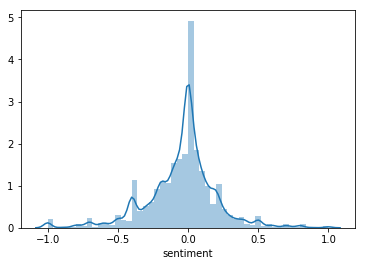

In [74]:
import seaborn as sns
sns.distplot(nrecom['sentiment'])

C:\Users\shshi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


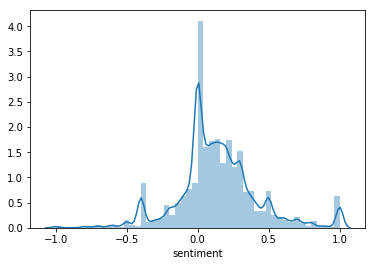

In [75]:
sns.distplot(recom['sentiment'])

In [ ]:
print(idx1)

In [ ]:
# split X

In [ ]:
review_df['game_name'].unique()

In [ ]:
print(sorted(scoring, key=lambda x: x[1], reverse=True))

In [ ]:
rev=review_df['review']
cleaned_data=list()
commonword=list()
bigrams=list()

for num in range(len(raw_review)):
    # find the most frequent double word used in each review
    each_bigram=list()
    for wordnum in range(len()-1):
        listitem=(clean[wordnum],clean[wordnum+1])
        each_bigram.append(listitem)
    bigrams.append(each_bigram)

In [ ]:
working_data=review_df.loc[(review_df['game_name'] == 'Arma_3')]
#print(working_data['review'][1])
cv = CountVectorizer(stop_words="english", analyzer='word',ngram_range=(1,1), max_df=1.0, min_df=0.6, max_features=None)
cv.fit(working_data['review'])
vector=cv.transform(working_data['review'])

In [ ]:
print(cv.get_feature_names())

In [ ]:
working_data=review_df.loc[(review_df['game_name'] == 'Arma_3')]
#print(working_data['review'][1])
cvt = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')
txt_fitted=cvt.fit(working_data['review'])
txt_transformed=txt_fitted.transform(working_data['review'])

In [ ]:
type(txt_fitted.get_feature_names())

In [ ]:
idf=cvt.idf_
scoring=list(zip(txt_fitted.get_feature_names(),idf))
print(sorted(scoring, key=lambda x: x[1], reverse=True))

In [ ]:
int(scoring[1][0])

In [ ]:
scoring_orig=scoring
print(scoring_orig[1][0])

In [ ]:
num_list=list()
num_list2=list()
for i in range(len(scoring)-1):
    try:
        int(scoring[i][0])
    except ValueError:
        num_list.append(scoring[i][0])
        num_list2.append(scoring[i][1])
        continue

In [ ]:
A_list=list(zip(num_list,num_list2))

In [ ]:
B_list=[item]

In [ ]:
raw_review[1]

In [ ]:
bigrams[len(cleaned_data)-1]

In [ ]:
raw_review[1]

In [ ]:
commonword[1]

In [ ]:
review_df['cleaned']=cleaned_data
review_df['frequent_words']=commonword
review_df['bigrams']=bigrams

In [ ]:
len(review_df)

In [ ]:
len(cleaned_data)

### Assign weight according to total playtime of each reviewer

In [ ]:
review_weight=list()
for each_game in review_df['game_name'].unique():
    working_data=review_df.loc[(review_df['game_name'] == each_game)]
    review_weight.extend(working_data['total_game_hours']/max(working_data['total_game_hours']))
review_df['review_weight']=review_weight

In [ ]:
review_df.head(3)

### Pull out words according to the review weight

In [ ]:
review_df['freq_word_values'] = review_df.apply(lambda row: list(row['frequent_words'].values()),axis=1)

In [ ]:
review_df['freq_word_keys'] = review_df.apply(lambda row: list(row['frequent_words'].keys()),axis=1)

In [ ]:
review_df['freq_word_weighted'] = review_df.apply(lambda row: [ i*row['review_weight']  for i in row['freq_word_values']],axis = 1)

In [ ]:
review_df['weighted_paired']=review_df.apply(lambda row: dict(zip(row['freq_word_keys'], row['freq_word_weighted'])),axis = 1)

In [ ]:
review_df.tail(3)

In [ ]:
review_df['weighted_paired'][1]

In [ ]:
key_df=pd.DataFrame(index=review_df['game_name'].unique(),columns=['key_word','key_bigram'])

In [ ]:
from collections import Counter
for each_game in review_df['game_name'].unique():
    working_data=review_df.loc[(review_df['game_name'] == each_game)]
    game_word=Counter()
    for pairs in working_data['weighted_paired']:
        game_word.update(pairs)
    key_df['key_word'][each_game]=game_word.most_common()

In [ ]:
bigram=defaultdict()
for each_game in review_df['game_name'].unique():
    working_data=review_df.loc[(review_df['game_name'] == each_game)]
    wordfreq[word]+=1

In [ ]:
key_df

In [ ]:
for each_game in review_df['game_name'].unique():
    working_data=review_df.loc[(review_df['game_name'] == each_game)]
    

In [ ]:
key_df['key_word']['Team_Fortress_2'][1:30]

In [ ]:
key_df['key_word']['Sid_Meiers_Civilization_5']

In [ ]:
len(working_data)

In [ ]:
sorted_by_value = sorted(game_word.items(), key=lambda kv: kv[1],reverse=True)

In [ ]:
print(sorted_by_value)

In [ ]:
from pattern.en import sentiment

In [ ]:
sentiment(raw_review[79436]).assessments[1]

In [ ]:
sentiment(raw_review[79436])

In [ ]:
key_df

In [ ]:
from collections import OrderedDict
result=defaultdict(int)
for each_game in review_df['game_name'].unique():
    working_data=review_df.loc[(review_df['game_name'] == 'Warframe')]
    for num in range(len(working_data['ranked_words'])):
        for word in working_data['ranked_words'].iloc[num]:
            result[word[1]]+=word[0]
    frequent_words=OrderedDict(sorted(result.items(), key=lambda t:t[1], reverse=True))
    for (key, value) in enumerate(frequent_words.items()):
        key_df['key_word']['Warframe']=frequent_words[0:100]
    #x=((value*working_data.review_weight,key) for key,value in commonword.items())   
    #ranked.extend(x)

In [ ]:
print((key for key, value in frequent_words.items()))

In [ ]:
type(key_df['key_word']['Warframe'])

In [ ]:
key_df

In [ ]:
result = defaultdict(int)

for d in lst:
    result[d['name']] += int(d['value'])

In [ ]:
print(sorted(ranked,reverse=True)[1:100])

In [ ]:
review_df.head(3)

In [ ]:
df.head()

In [ ]:
print(weighted_list)

In [ ]:
review1=pd.DataFrame(reviewdata['Warframe'])

In [ ]:
s=sum(review1['total_game_hours'])

In [ ]:
type([review1['total_game_hours']/s])

In [ ]:
reviewex=reviewdata['Warframe'][99]['review']
print(reviewex)

In [ ]:
cleaned=reviewdata['Warframe'][99]['cleaned review']
print(cleaned)

In [ ]:
print(reviewdata['Warframe'][99]['frequent words'])

In [ ]:
wordfreq=defaultdict(int)

In [ ]:
wordfreq.items()

In [ ]:
type(wordfreq)

In [ ]:
cleaned_data=list()
commonword=list()
bigrams=list()

for num in range(len(raw_review)):
    review=raw_review.iloc[num]
    # split the words into 'tokens'
    tokens=word_tokenize(review)
    # lowercase every tokens
    lower_tokens=[token.lower() for token in tokens]
    # remove stopwords and punctuation from the words
    words=[word for word in lower_tokens if word not in stop_words]
    clean=[str(word) for word in words if word.isalpha()]
    cleaned_data.append(clean)
    
    # find the most frequent single word used in each review
    wordfreq=defaultdict(int)
    for word in clean:
        wordfreq[word]+=1
    commonword.append(wordfreq)
        
    # find the most frequent double word used in each review
    each_bigram=list()
    for wordnum in range(len(clean)-1):
        listitem=(clean[wordnum],clean[wordnum+1])
        each_bigram.append(listitem)
    bigrams.append(each_bigram)

In [ ]:
for each_name in review_df['game_name'].unique():
    working_data=review_df.loc[(review_df['game_name'] == each_name)][['game_name','review']]
    if 'sample_review' not in locals():
        sample_review=pd.DataFrame(columns=['game_name','review'])
        sample_review=working_data.sample(99)
    else:
        sample_review=sample_review.append(working_data.sample(99))

In [ ]:
writer=pd.ExcelWriter('E:\Desktop\Sample_Reviews.xlsx')
sample_review.to_excel(writer,'Sheet1')
writer.save()
del sample_review

In [ ]:
for each_name in review_df['game_name'].unique():
    working_data=review_df.loc[(review_df['game_name'] == each_name)][['game_name','review']]
    if 'all_review' not in locals():
        all_review=pd.DataFrame(columns=['game_name','review'])
        all_review=working_data[['game_name','review']]
    else:
        all_review=all_review.append(working_data[['game_name','review']])

In [ ]:
writer=pd.ExcelWriter('E:\Desktop\all_Reviews.xlsx')
review_df[['game_name','review']].to_excel(writer,'Sheet1')
writer.save()

In [ ]:
review_df.sample(frac=0.1,replace=False)

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

In [ ]:
sentiment=list()
sid = SentimentIntensityAnalyzer()
for sentence in raw_review.head():
    ss = sid.polarity_scores(sentence)
    sentiment.append(ss['compound'])
     #for k in ss:
      #   print('{0}: {1}, '.format(k, ss[k]))
#review_df['sentiment']=sentiment


In [ ]:
raw_review[0]

In [ ]:
review_df.head(30)

In [ ]:
set(review_df.rating)

In [ ]:
recom=review_df[review_df['rating']=='Recommended']
nrecom=review_df[review_df['rating']=='Not Recommended']

C:\Users\shshi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


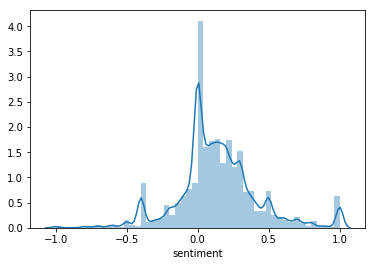

C:\Users\shshi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


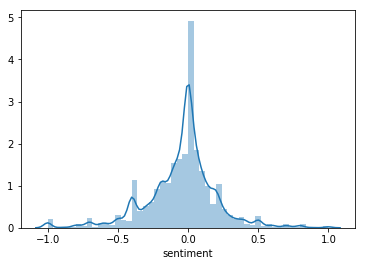